# Notes

- I finally understood, that during traingin each next token is calculated simultaneously for the whole sentence, such that no sequential processing is needed. That is of course redundant for inference. 

# Imports

In [49]:
# logging and decorators
import logging as log
import functools
import time

# system tools
import pathlib
import os
import glob

# general modules
import numpy as np
import math
import copy

# tensorflow modules
import tensorflow as tf
import tensorflow_text as tf_text
from tensorflow.keras import layers
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

# necessary for visualization and user input
import matplotlib.pyplot as plt


# Settings

In [50]:
# logging settings
log.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
        # log.INFO for normal run
    level=log.INFO,
        # log.DEBUG for diagnostics
    # level=log.DEBUG,
    datefmt='%Y-%m-%d %H:%M:%S')
log_enabled = True

# Set True, if code is run as jupyter notebook
is_interactive_notebook = True

# paths
corpus_dataset_path = 'datasets\\corpus.txt'
tight_fit_512_dataset_path = 'datasets\\tight_fit_dataset_512.txt'
vocab_path = 'datasets\\vocab.txt'

# tokenizer
tokenizer_name = 'story_corpus_tokenizer'
reserved_tokens = ["[PAD]", "[UNK]", "[START]", "[END]"]

# Decorators

In [51]:
def log_dec(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            if log_enabled and not kwargs.get('training') is None:
                start_time = time.time()
                class_name = func.__qualname__.split('.')[0]
                log.info(f'{class_name}.{func.__name__} called')
            return func(*args, **kwargs)
        except Exception as ex:
            raise ex
        finally:
            if log_enabled and not kwargs.get('training') is None:
                duration = time.time() - start_time
                log.info(f'{class_name}.{func.__name__} executed')
    return wrapper

# Architecture

## Helper functions

In [52]:
def do_nothing(*args, **kwargs):
    pass

def clones(module, N):
    """Produce N identical layers"""
    return [copy.deepcopy(module) for _ in range(N)]

def clones_alt(layer_class, N, **kwargs):
    """Produce N identical layers"""
    return [layer_class(**kwargs) for layer_number in range(N)]

def subsequent_mask(size):
    """Mask out subsequent positions."""
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return subsequent_mask == 0

### Layer Wrapper

In [53]:
class ModuleVisualWrapper():
    visualize = True
    instances = []

    def __init__(self, vis_on_count=None, enabler=False):
        self.counter = 0
        self.vis_on_count = vis_on_count if vis_on_count else []
        self.enabler = enabler
        ModuleVisualWrapper.instances.append(self)

    def visualize_data(self, data, mode, text=None, training=None):
        if training is False:
            # check for visualisation param of the instance and visualize or change class settings
            if self.counter in self.vis_on_count:
                tf.print(text)    
                if self.visualize:
                    self.choose_func(mode)(data)
                if self.enabler:
                    ModuleVisualWrapper.visualize = True
            else:
                if self.enabler:
                    ModuleVisualWrapper.visualize = False
            self.counter += 1

    # @log_dec
    def choose_func(self, mode):
        if mode == 'color_bar':
            return lambda x: self.color_bar(x)
        elif mode == 'print':
            return lambda x: self.print_data(x)
        else:
            return do_nothing

    def color_bar(self, array_data):
        # Assuming data[0] is a numpy array.
        # If it's a ListWrapper or another list-like object, convert it to a numpy array.
        array_data = np.array(array_data[0])
        # If the array is 1D, reshape it into a 2D array with one column
        if array_data.ndim == 1:
            array_data = np.reshape(array_data, (-1, 1))
        # Set the size of the plot (you can adjust the dimensions as needed)
        plt.figure(figsize=(10, 2))
        # Use imshow to create a color-coded visualization and display it
        plt.imshow(array_data, cmap='jet', aspect='auto')
        plt.colorbar(label='Tensor Value')
        plt.show()
        
    def print_data(self,data):
        tf.print(data)

    @classmethod
    def reset_counter(cls):
        for instance in cls.instances:
            instance.counter = 0

In [54]:
class LayerWrapper(layers.Layer):
    """
    A wrapper for Keras layers, which allows to visualize data at each layer.

    Attributes:
        should_visualize (bool): Class attribute controlling whether visualization should occur.
        layer (Layer): The Keras layer to be wrapped.
        inputs (List[Tensor]): Inputs to the layer during calls.
        outputs (List[Tensor]): Outputs of the layer during calls.
        counter (int): Counter of layer calls.
        visualize_on_calls (List[int]): List of call counts at which to visualize.
        visualizations (List[Tuple[str, str]]): List of visualization modes and what to visualize.
        visual_setter (bool): If True, this instance can change the should_visualize class variable.
    """
    should_visualize = True  # class variable

    def __init__(self, layer, visualize_on_calls=None, visualizations=None, visual_setter=False, **kwargs):
        """
        Initialize the LayerCallWrapper
        Args:
            layer (Layer): The Keras layer to be wrapped.
            visualize_on_calls (List[int], optional): List of call counts at which to visualize. Defaults to empty list.
            visualizations (List[Tuple[str, str]], optional): List of visualization modes and what to visualize. Defaults to an empty list.
            visual_setter (bool, optional): If True, this instance can change the should_visualize class variable. Defaults to False.
            **kwargs: Additional keyword arguments.u
        """
        super().__init__(**kwargs)
        self.layer = layer
        self.inputs = []
        self.outputs = []
        self.counter = 0
        self.visualize_on_calls = visualize_on_calls if visualize_on_calls else []
        self.visualizations = visualizations if visualizations else []
        self.visual_setter = visual_setter

    def __getattr__(self, attr):
        """
        Overloads the attributte access in order to access the wrapped layers attribute if not found in the wraper
        """
        if 'layer' in self.__dict__:
            return getattr(self.layer, attr)
        else:
            raise AttributeError(f"{self.__class__.__name__} object has no attribute {attr}")
 
    def call(self, *args, **kwargs):
        """
        Overloads the call to the layer, allowing to capture inputs and outputs, and visualize if needed.

        Args:
            *args: Variable length argument list.
            **kwargs: Arbitrary keyword arguments.

        Returns:
            Tensor: The output of the layer call.
        """

        self.inputs.append([arg for arg in args])
        output = self.layer(*args, **kwargs)

        tf.print(f'shape of {self.__class__.__name__}.{self.layer.__class__.__name__} out', tf.shape(output))
        tf.print(f'dtype of {self.__class__.__name__}.{self.layer.__class__.__name__} out', output.dtype)
        
        if kwargs.get('training') is False:
            self.outputs.append(output)

            # check for visualisation param of the instance and visualize or change class settings
            if self.counter in self.visualize_on_calls:
                if self.should_visualize:
                    self.visualize(self.visualizations)
                if self.visual_setter:
                    LayerWrapper.should_visualize = True
            else:
                if self.visual_setter:
                    LayerWrapper.should_visualize = False

            self.counter += 1
        return output
    
    @staticmethod
    def wait_for_user_input():
        # waits for user input, if not jupyter notebook
        # causes problems in jupyter
        if not is_interactive_notebook:
            proceed = input('Continue')

    # @log_dec
    def visualize(self, visualizations):
        for mode, what_to_output in visualizations:
            if what_to_output == 'x':
                data = self.inputs[-1]
            elif what_to_output == 'y':
                data = self.outputs[-1]
            elif what_to_output == 'y-x':
                data = [output - input for input, output in zip(self.inputs[-1], self.outputs[-1])]

            continue

            if mode == 'mode1':
                self.visualization_func_1(data)
            elif mode == 'mode2':
                self.visualization_func2(data)

        self.wait_for_user_input()

    def visualization_func_1(self, data):
        # Assuming data[0] is a numpy array.
        # If it's a ListWrapper or another list-like object, convert it to a numpy array.
        array_data = np.array(data[0])
        # If the array is 1D, reshape it into a 2D array with one column
        if array_data.ndim == 1:
            array_data = np.reshape(array_data, (-1, 1))
        # Set the size of the plot (you can adjust the dimensions as needed)
        plt.figure(figsize=(10, 2))
        # Use imshow to create a color-coded visualization and display it
        plt.imshow(array_data, cmap='jet', aspect='auto')
        plt.colorbar(label='Tensor Value')
        plt.show()
        
    def visualization_func2(self, data):
        # Your visualization code here
        pass

## Main Layers

These classes are built using the Keras Functional API, which provides more flexibility than the Sequential API for defining complex models. Each class is a subclass of tf.keras.layers.Layer, so they can be composed to build more complex layers or models. The call method of each class defines the computation that the layer performs.

These classes are designed to be components of a larger transformer model. The model itself is typically composed of an encoder and a decoder, each of which is made up of a stack of identical layers. The layers themselves contain sublayers that perform operations such as self-attention, source attention (in the case of the decoder), and position-wise feed-forward networks. These operations are encapsulated within classes like `EncoderStack`, `DecoderStack`, `EncoderLayer`, `DecoderLayer`, and `PositionwiseFeedForward`. The layer norm and dropout are applied in `ResidualSublayer` for regularizing and speeding up the training process.

### Encoder Decoder Layer

1. `EncoderDecoder`:
    - `__init__(self, encoder, decoder, enc_embed, dec_embed, generator)`: This initializes the EncoderDecoder instance. It takes in five arguments:
        - `encoder`: The encoder layer to be used.
        - `decoder`: The decoder layer to be used.
        - `enc_embed`: The embedding layer for the encoder.
        - `dec_embed`: The embedding layer for the decoder.
        - `generator`: The final layer that generates the output tokens.
    - `encode(self, inputs, pad_mask)`: This method is used to encode the inputs using the encoder layer. It takes in two arguments:
        - `inputs`: The input tokens to be encoded.
        - `pad_mask`: The mask indicating which tokens are padding.
    - `decode(self, enc_input, pad_mask, inputs, subseq_mask)`: This method is used to decode the encoded inputs using the decoder layer. It takes in four arguments:
        - `enc_input`: The encoded input from the encoder.
        - `pad_mask`: The mask indicating which tokens are padding in the encoded input.
        - `inputs`: The target tokens to be decoded.
        - `subseq_mask`: The mask indicating which tokens in the target sequence should not be attended to.
    - `call(self, enc_input, dec_input, pad_mask, subseq_mask)`: This method is used to perform the complete transformation from input tokens to output tokens. It takes in four arguments that are the same as those described in the `encode` and `decode` methods.

In [55]:
# @LayerWrapperDecorator(visualize_on_calls=[1], visual_setter=True)
class EncoderDecoder(tf.keras.Model, ModuleVisualWrapper):
    def __init__(self, encoder_stack, decoder_stack, enc_embed, dec_embed, generator):
        super().__init__()
        ModuleVisualWrapper.__init__(self, vis_on_count=[0], enabler=True)
        # modules
        self.encoder_stack = encoder_stack
        self.decoder_stack = decoder_stack
        self.enc_embed = enc_embed
        self.dec_embed = dec_embed
        self.generator = generator

    # @log_dec
    def encode(self, inputs, pad_mask, training=None):
        return self.encoder_stack(self.enc_embed(inputs), pad_mask, training=training)
    
    # @log_dec
    def decode(self, enc_input, pad_mask, inputs, subseq_mask, training=None):
        return self.decoder_stack(self.dec_embed(inputs), enc_input, pad_mask, subseq_mask, training=training)

    # @log_dec
    def call(self, inputs, training=None):

        enc_input, dec_input, pad_mask, subseq_mask = inputs

        return self.decode(self.encode(enc_input, pad_mask, training), 
                           pad_mask,
                           dec_input, 
                           subseq_mask, training)

### Layer Norm


2. `LayerNorm`:
    - `__init__(self, features, eps=1e-6)`: This initializes the LayerNorm instance. It takes in two arguments:
        - `features`: The number of features in the input to be normalized.
        - `eps`: A small number to add to the denominator for numerical stability.
    - `call(self, x)`: This method is used to apply layer normalization to the input. It takes in one argument:
        - `x`: The input to be normalized.

In [56]:
class LayerNorm(layers.Layer, ModuleVisualWrapper):

    def __init__(self, features, eps=1e-6) -> None:
        super().__init__()
        ModuleVisualWrapper.__init__(self, vis_on_count=[0])
        self.a_2 = self.add_weight(shape=(features,), initializer='ones', name=self.name + "a_2")
        self.b_2 = self.add_weight(shape=(features,), initializer='zeros', name=self.name + "b_2")
        self.eps = eps

    # @log_dec
    def call(self, x):
        mean, var = tf.nn.moments(x, axes=-1, keepdims=True)
        std = tf.math.sqrt(var + self.eps)
        return self.a_2 * (x - mean) / std + self.b_2

### Residual Layer


3. `ResidualSublayer`:
    - `__init__(self, size, dropout)`: This initializes the ResidualSublayer instance. It takes in two arguments:
        - `size`: The number of features in the input.
        - `dropout`: The dropout rate to be applied after the sublayer.
    - `call(self, x, sublayer)`: This method is used to apply a sublayer and a residual connection to the input. It takes in two arguments:
        - `x`: The input to be transformed.
        - `sublayer`: The sublayer to be applied to the input. This is expected to be a function or callable object that takes in the input and returns a tensor of the same shape.

In [57]:
class ResidualSublayer(layers.Layer, ModuleVisualWrapper):
    """
    A residual connection followed by a layer norm. Note for code simplicity the norm is first as opposed to last.
    """

    def __init__(self, size, dropout) -> None:
        super().__init__()
        ModuleVisualWrapper.__init__(self, vis_on_count=[0])
        self.norm = LayerNorm(size)
        self.dropout = layers.Dropout(dropout)

    # @log_dec
    def call(self, x, sublayer, training=None):
        "Apply residual connection to any sublayer with the same size."
        sublayer_out = sublayer(self.norm(x))
        return x + self.dropout(sublayer_out, training=training)

### Encoder Stack Layer

4. `EncoderStack`:
    - `__init__(self, layer, N)`: This initializes the EncoderStack instance. It takes in two arguments and initializes two instance variables:
        - `layer`: The type of layer to be used in the encoder stack. This should be a callable object that takes in the input and a mask and returns a tensor.
        - `N`: The number of layers in the encoder stack.
        - `self.layers` is a list of `N` layer clones of the type `layer`.
        - `self.norm` is the norm layer, that is applied to the output of the `EncoderStack`.
    - `call(self, x, mask)`: This method is used to pass the input through each layer in the encoder stack in turn. It takes in two arguments:
        - `x`: The input to be processed by the encoder stack.
        - `mask`: The mask indicating which tokens should not be attended to.

In [58]:
class EncoderStack(layers.Layer, ModuleVisualWrapper):
    """
    Core encoder is a stack of N=6 Layers
    """

    def __init__(self, layer, N, size, **kwargs):
        super().__init__()
        ModuleVisualWrapper.__init__(self, vis_on_count=[0])
        self.layers = clones_alt(layer, N, size=size, **kwargs)
        self.norm = LayerNorm(size)

    # @log_dec
    def call(self, x, mask, training=None):
        """
        Pass the input (and mask) through each layer in turn
        """
        for layer in self.layers:
            x = layer(x, mask, training=training)
        return self.norm(x)

### Encoder Layer


5. `EncoderLayer`:
    - `__init__(self, size, self_attn, feed_forward, dropout)`: This initializes the EncoderLayer instance. It takes in four arguments:
        - `size`: The number of features in the input.
        - `self_attn`: The self-attention mechanism to be used in the encoder layer. This should be a callable object that takes in the input and a mask and returns a tensor.
        - `feed_forward`: The feed-forward network to be used in the encoder layer. This should be a callable object that takes in the input and returns a tensor.
        - `dropout`: The dropout rate to be applied after each sublayer.
    - `call(self, x, mask)`: This method is used to pass the input through the self-attention mechanism and the feed-forward network. It takes in two arguments:
        - `x`: The input to be processed by the encoder layer.
        - `mask`: The mask indicating which tokens should not be attended to.

In [59]:
class EncoderLayer(layers.Layer, ModuleVisualWrapper):
    """
    Encoder is made up of a self-attention and a feed forward layer 
    """

    def __init__(self, size, self_attn, feed_forward, dropout):
        super().__init__()
        ModuleVisualWrapper.__init__(self, vis_on_count=[0])
        self.size = size
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones_alt(ResidualSublayer, N=2, size=size, dropout=dropout)

    # @log_dec
    def call(self, x, mask, training=None):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask, training=training), training=training)
        return self.sublayer[1](x, lambda x: self.feed_forward(x, training=training), training=training)

### Decoder Stack Layer

6. `DecoderStack`:
    - `__init__(self, layer, N)`: This initializes the DecoderStack instance. It takes in two arguments and initializes two instance variables:
        - `layer`: The type of layer to be used in the decoder stack. This should be a callable object that takes in the input, the memory from the encoder, a source mask, and a target mask, and returns a tensor.
        - `N`: The number of layers in the decoder stack.
        - `self.layers` is a list of `N` layer clones of the type `layer`.
        - `self.norm` is the norm layer, that is applied to the output of the `EncoderStack`.
    - `call(self, x, memory, src_mask, tgt_mask)`: This method is used to pass the input through each layer in the decoder stack in turn. It takes in four arguments:
        - `x`: The input to be processed by the decoder stack.
        - `memory`: The output of the encoder, which serves as the memory for the decoder.
        - `src_mask`: The mask indicating which tokens in the source sequence should not be attended to.
        - `tgt_mask`: The mask indicating which tokens in the target sequence should not be attended to.

In [60]:
class DecoderStack(layers.Layer, ModuleVisualWrapper):
    """
    Generic N layer decoder with masking
    """

    def __init__(self, layer, N, size, **kwargs):
        super().__init__()
        ModuleVisualWrapper.__init__(self, vis_on_count=[0])
        self.layers = clones_alt(layer, N, size=size, **kwargs)
        self.norm = LayerNorm(size)

    # @log_dec
    def call(self, x, memory, src_mask, tgt_mask, training=None):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask, training=training)
        return self.norm(x)

### Decoder Layer

7. `DecoderLayer`:
    - `__init__(self, size, self_attn, src_attn, feed_forward, dropout)`: This initializes the DecoderLayer instance. It takes in five arguments:
        - `size`: The number of features in the input.
        - `self_attn`: The self-attention mechanism to be used in the decoder layer. This should be a callable object that takes in the input and a mask and returns a tensor.
        - `src_attn`: The source attention mechanism to be used in the decoder layer. This should be a callable object that takes in the input, the memory from the encoder, and a mask, and returns a tensor.
        - `feed_forward`: The feed-forward network to be used in the decoder layer. This should be a callable object that takes in the input and returns a tensor.
        - `dropout`: The dropout rate to be applied after each sublayer.
    - `call(self, x, memory, src_mask, tgt_mask)`: This method is used to pass the input through the self-attention mechanism, the source attention mechanism, and the feed-forward network. It takes in four arguments:
        - `x`: The input to be processed by the decoder layer.
        - `memory`: The output of the encoder, which serves as the memory for the decoder.
        - `src_mask`: The mask indicating which tokens in the source sequence should not be attended to.
        - `tgt_mask`: The mask indicating which tokens in the target sequence should not be attended to.

In [61]:
class DecoderLayer(layers.Layer, ModuleVisualWrapper):
    """
    Decoder is made of self-attn, source-attn and feedforward layer
    """

    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super().__init__()
        ModuleVisualWrapper.__init__(self, vis_on_count=[0])
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones_alt(ResidualSublayer, N=3, size=size, dropout=dropout)

    # @log_dec
    def call(self, x, memory, src_mask, tgt_mask, training=None):
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

## Sublayers

### Feedforward Layer

8. `PositionwiseFeedForward`:
    - `__init__(self, d_model, d_ff, dropout=0.1, *args, **kwargs)`: This initializes the PositionwiseFeedForward instance. It takes in three arguments and an optional set of arguments:
        - `d_model`: The number of features in the input.
        - `d_ff`: The number of features in the hidden layer of the feed-forward network.
        - `dropout`: The dropout rate to be applied after the first layer of the feed-forward network.
        - `*args, **kwargs`: Additional arguments that might be necessary for the parent class initialization.
    - `call(self, x)`: This method is used to pass the input through the feed-forward network. It takes in one argument:
        - `x`: The input to be processed by the feed-forward network.

In [62]:
class PositionwiseFeedForward(layers.Layer, ModuleVisualWrapper):
    """Implements FFN equation"""

    def __init__(self, d_model, d_ff, dropout=0.1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        ModuleVisualWrapper.__init__(self, vis_on_count=[0])
        self.w_1 = layers.Dense(d_ff)
        self.w_2 = layers.Dense(d_model)
        self.dropout = layers.Dropout(dropout)

    # @log_dec
    def call(self, x, training=None):
        return self.w_2(self.dropout(tf.nn.relu(self.w_1(x)), training=training))

### Generator Layer

9. `Generator`:
    - `__init__(self, vocab)`: This method initializes the Generator instance. It accepts one argument:
        - `vocab`: The size of the vocabulary which will be the number of output units in the dense layer.
    - `call(self, x)`: This method is used to pass the input through the generator. It takes in one argument:
        - `x`: The input tensor to be processed by the generator. The method returns the log softmax of the output of the dense layer.

In [63]:
# @LayerWrapperDecorator(visualize_on_calls=[1], visualizations=[('mode1', 'x')])
class Generator(layers.Layer, ModuleVisualWrapper):
    """
    Define standard linear + softmax generation step
    """

    def __init__(self, vocab):
        super().__init__()
        ModuleVisualWrapper.__init__(self, vis_on_count=[0])
        self.proj = layers.Dense(vocab)

    # @log_dec
    def call(self, x, training=None):
        result = tf.nn.log_softmax(self.proj(x), axis=-1)
        self.visualize_data(result, 
                            'color_bar', 
                            text=f"This is the data from {self.__class__.__name__}", 
                            training=training)
        return result

### Attention Layer


10. `attention(query, key, value, mask=None, dropout=None)`:
    - This is a function that computes the 'Scaled Dot Product Attention'. The arguments are as follows:
        - `query`, `key`, `value`: These are the main inputs to the attention function.
        - `mask`: Optional mask for the attention scores.
        - `dropout`: Optional dropout rate to be applied to the attention scores.
    - The function first scales the dot product of the query and key, applies the mask if provided, applies softmax to compute attention scores, applies dropout if provided, and then uses the attention scores to compute a weighted sum of the value inputs.

In [64]:
# @log_dec
def attention(query, key, value, mask=None, dropout=None, training=None):
    "Compute 'Scaled Dot Product Attention'"

    d_k = query.shape[-1]
    scores = tf.matmul(query, tf.transpose(key, perm=[0, 1, 3, 2])) / math.sqrt(d_k)
    if mask is not None:
        mask = tf.cast(mask, dtype=tf.bool)
        scores = tf.where(mask, scores, tf.fill(tf.shape(scores), -1e9))
    p_attn = tf.nn.softmax(scores, axis=-1)
    if dropout is not None:
        p_attn = dropout(p_attn, training=training)
    return tf.matmul(p_attn, value), p_attn

11. `MultiHeadedAttention`:
    - `__init__(self, h, d_model, dropout=0.1)`: This initializes the MultiHeadedAttention instance. It takes in three arguments:
        - `h`: The number of attention heads.
        - `d_model`: The number of features in the input.
        - `dropout`: The dropout rate to be applied after the softmax in the attention computation.
    - `call(self, query, key, value, mask=None)`: This method is used to compute the multi-headed attention over the inputs. It takes in four arguments:
        - `query`, `key`, `value`: These are the main inputs to the attention computation.
        - `mask`: Optional mask for the attention scores.
    - The method first computes the linear projections of the inputs, applies the attention function to the projected inputs, concatenates the outputs of the attention function across the attention heads, and then applies a final linear transformation to the concatenated outputs.

In [65]:
class MultiHeadedAttention(layers.Layer, ModuleVisualWrapper):
    
    def __init__(self, h, d_model, dropout=0.1, **kwargs):
        super().__init__()
        ModuleVisualWrapper.__init__(self, vis_on_count=[0])
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.query, self.key, self.value, self.linear = clones_alt(layers.Dense, N=4, units=d_model)
        self.attn = None
        self.dropout = layers.Dropout(dropout)

    # @log_dec
    def call(self, query, key, value, mask=None, training=None):
        if mask is not None:
            # Same mask applied to all h heads
            mask = tf.expand_dims(mask, 1)

        nbatches = tf.shape(query)[0]

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [
            tf.transpose(tf.reshape(lin(x), [nbatches, -1 , self.h, self.d_k]), perm=[0, 2, 1, 3]) 
            for lin, x in zip(
                [self.query, self.key, self.value], 
                (query, key, value))
        ]

        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout, training=training)

        # 3) "Concat" using a view and apply a final linear.
        x = tf.reshape(tf.transpose(x ,perm=[0, 2, 1, 3]), (nbatches, -1, self.h * self.d_k))

        return self.linear(x)

### Positional Embedding Layer

12. `positional_encoding(length, depth)`:
    - This is a function that computes the positional encoding for a sequence of a given length and depth. The arguments are as follows:
        - `length`: The length of the sequence for which positional encoding is to be computed.
        - `depth`: The number of features in the input sequence.
    - The function first computes the rates at which the angles should change across the positions and depths, then computes the angles at each position and depth, and finally applies sine to the angles at the even indices and cosine to the angles at the odd indices. The positional encoding for a position is thus a vector of these sine and cosine values.

In [66]:
# @log_dec
def positional_encoding(length, depth):
    depth = depth / 2

    positions = np.arange(length)[:, np.newaxis]   # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth  # (1, depth)

    angle_rates = 1 / (10000**depths)               # (1, depth)
    angle_rads  = positions * angle_rates           # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1
        )

    return tf.cast(pos_encoding, dtype=tf.float32)

13. `PositionalEmbedding`:
    - `__init__(self, vocab_size, d_model)`: This method initializes the PositionalEmbedding instance. It takes in two arguments:
        - `vocab_size`: The size of the vocabulary, which will be the input dimension of the embedding layer.
        - `d_model`: The number of features to be output by the embedding layer and the depth for the positional encoding.
    - `call(self, x)`: This method is used to compute the positionally encoded embeddings of the inputs. It takes in one argument:
        - `x`: The input tensor for which the embeddings are to be computed.
    - The method first computes the embeddings of the inputs, scales the embeddings by the square root of `d_model`, and then adds the positional encoding to these scaled embeddings.

In [67]:
class PositionalEmbedding(layers.Layer, ModuleVisualWrapper):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        ModuleVisualWrapper.__init__(self, vis_on_count=[0])
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    # @log_dec
    # @tf.function
    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positional_encoding
        x *=tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        # TODO: Dropout is missing
        return x

## Model Generation

### Make model

14. `make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1)`:
    - The `make_model` function constructs a Transformer model from given hyperparameters. It takes seven arguments:
        - `src_vocab`: The size of the source vocabulary.
        - `tgt_vocab`: The size of the target vocabulary.
        - `N`(default=6): The number of layers in the Transformer's Encoder and Decoder stacks.
        - `d_model`(default=512): The dimension of the model. It's the number of features in input and output.
        - `d_ff`(default=2048): The number of features in the hidden layer of the feed-forward network.
        - `h`(default=8): The number of attention heads in the MultiHeadedAttention mechanism.
        - `dropout`(default=0.1): The dropout rate to be applied in several parts of the model.
    - Inside this function, instances of `MultiHeadedAttention` and `PositionwiseFeedForward` are created. These instances are then deep-copied and used to construct the Encoder and Decoder stacks, additionally the PositionalEmbeddings, and the Generator are instantiated. All these parts are then assembled into a `EncoderDecoder` instance, which includes the complete Transformer model. If a module is wrapped with a `LayerWrapper` this is in order to visualize the output of this layer on sucessive calls. Look for the specific meaning of the `LayerWrapper` parameters in the definition of the class.
    - Finally, the function returns the constructed model. 

In [26]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1) -> tf.keras.Model:
    "Helper: Construct a model from hyperparameters."
    
    model = EncoderDecoder(
                EncoderStack(
                    EncoderLayer,
                    N=N, 
                    size=d_model, 
                    dropout=dropout, 
                    self_attn=MultiHeadedAttention(h, d_model), 
                    feed_forward=PositionwiseFeedForward(d_model, d_ff, dropout)),
                DecoderStack(
                    DecoderLayer, 
                    N=N, 
                    size=d_model, 
                    dropout=dropout,
                    self_attn=MultiHeadedAttention(h, d_model), 
                    src_attn=MultiHeadedAttention(h, d_model), 
                    feed_forward=PositionwiseFeedForward(d_model, d_ff, dropout)),
                PositionalEmbedding(
                    src_vocab, 
                    d_model),
                PositionalEmbedding(
                    tgt_vocab, 
                    d_model),
                Generator(tgt_vocab)
            )

    return model

# Training

## Data Preparation

### Tokenizer

In [27]:
class StoryTokenizer(tf.Module, ModuleVisualWrapper):
    def __init__(self, reserved_tokens, vocab_path):    
        super().__init__()
        ModuleVisualWrapper.__init__(self, vis_on_count=[0])
        self.tokenizer = tf_text.BertTokenizer(vocab_path, lower_case=True)
        self._reserved_tokens = reserved_tokens
        self._vocab_path = tf.saved_model.Asset(vocab_path)

        vocab = pathlib.Path(vocab_path).read_text().splitlines()
        self.vocab = tf.Variable(vocab)        

    def tokenize(self, strings, training=None):

        encoded = self.tokenizer.tokenize(strings)
        merged_enc = encoded.merge_dims(-2, -1)
        out = self.add_start_end(merged_enc)

        self.visualize_data(self.lookup(out),
                            mode='print', 
                            text=f"This is the data from {self.__class__.__name__}", 
                            training=training)

        return out
    
    def detokenize(self, tokenized, training=None):
        words = self.tokenizer.detokenize(tokenized)
        return self.cleanup_text(self._reserved_tokens, words)
    
    def lookup(self, token_ids):
        return tf.gather(self.vocab, token_ids)

    @staticmethod
    def add_start_end(ragged):
        START = tf.argmax(tf.constant(reserved_tokens) == "[START]")
        END = tf.argmax(tf.constant(reserved_tokens) == "[END]")

        count = ragged.bounding_shape()[0]
        starts = tf.fill([count, 1], START)
        ends = tf.fill([count, 1], END)
        return tf.concat([starts, ragged, ends], axis=1)

    @staticmethod
    def cleanup_text(reserved_tokens, token_txt):
        bad_tokens = list(filter(lambda token: token != "[UNK]", reserved_tokens))
        bad_tokens_re = "|".join(bad_tokens)

        bad_cells = tf.strings.regex_full_match(token_txt, bad_tokens_re)
        ragged_result = tf.ragged.boolean_mask(token_txt, ~bad_cells)

        result = tf.strings.reduce_join(ragged_result, separator=' ', axis=-1)

        return result
    
    def get_vocab_size(self):
        return tf.shape(self.vocab)[0]
    
    def get_vocab_path(self):
        return self._vocab_path
    
    def get_reserved_tokens(self):
        return tf.constant(self._reserved_tokens)

### Vocabulary Generation

In [28]:
def load_dataset(dataset_text_file):
    return tf.data.TextLineDataset(filenames=dataset_text_file)

def create_vocab(dataset):
    bert_vocab_args=dict(
        vocab_size = 8000,
        reserved_tokens = ["[PAD]", "[UNK]", "[START]", "[END]"],
        bert_tokenizer_params = dict(lower_case=True),
        learn_params = {},
    )

    story_vocab = bert_vocab.bert_vocab_from_dataset(
        dataset.batch(1000).prefetch(2),
        **bert_vocab_args
    )
    return story_vocab

def create_vocab_from_textdata(text_file=corpus_dataset_path):
    dataset = load_dataset(text_file)
    vocab = create_vocab(dataset)
    return vocab

def write_vocab_file(filepath, vocab):
    with open(filepath, 'w') as file:
        for token in vocab:
            print(token, file=file)

### Dataset generator

In [29]:
@log_dec
def load_tokenizer(tokenizer_name):
    return tf.saved_model.load(tokenizer_name)

@log_dec
def create_datasets(file_path, tokenizer, buffer_size=20000, batch_size=64, max_padding=128, pad_id=0):
    # Create a Dataset from the text file
    lines_dataset = tf.data.TextLineDataset(file_path)

    # Tokenize the whole dataset with the pre-trained tokenizer
    tokenized_dataset = (lines_dataset
                         .shuffle(buffer_size)
                         .batch(batch_size)
                         .map(lambda x: prepare_datapoint(x,tokenizer, max_padding=128, pad_id=0))
                         .prefetch(buffer_size=tf.data.AUTOTUNE))

    # Determine the number of lines for training (80% for this example)
    num_lines = sum(1 for _ in tokenized_dataset)
    num_train = int(0.8 * num_lines)

    # Split the data into train and validation datasets
    train_dataset = tokenized_dataset.take(num_train)
    valid_dataset = tokenized_dataset.skip(num_train)

    return train_dataset, valid_dataset

@log_dec
def prepare_datapoint(data_point, tokenizer, max_padding, pad_id=0):
    
    src_tokens = tokenizer.tokenize(data_point)
    tgt_tokens = src_tokens[:, :-1]
    label_tokens = src_tokens[:, 1:]

    src = src_tokens.to_tensor(shape=[1, max_padding], default_value=pad_id)
    tgt = tgt_tokens.to_tensor(shape=[1, max_padding], default_value=pad_id)
    label = label_tokens.to_tensor(shape=[1, max_padding], default_value=pad_id)
    
    src_mask = (src != pad_id)[:, np.newaxis, :]
    tgt_mask = make_std_mask(tgt, pad_id)

    return (src, tgt, src_mask, tgt_mask), label

@log_dec
def make_std_mask(tgt, pad_id):
    "Create a mask to hide padding and future words."
    tgt_mask = (tgt != pad_id)[:, np.newaxis, :]
    tgt_mask = tf.logical_and(tgt_mask, subsequent_mask(tgt.shape[-1]))
    return tgt_mask

## Training

### Loss function

In [68]:
class LabelSmoothingLoss(layers.Layer, ModuleVisualWrapper):
    """
    This class represents a loss function layer that applies label smoothing to prevent overconfidence 
    in the model's predictions. This is done by replacing the 0s and 1s in the labels with smoothed values, 
    such that the model learns to be less confident and thus, more robust.

    Args:
        vocab_size (int): The size of the vocabulary, which also represents the number of classes.
        padding_idx (int): The index representing padding elements.
        smoothing (float): The smoothing factor to be applied. The values should be between 0 and 1. 
                           Default value is 0.
        reduction (tf.keras.losses.Reduction): The type of reduction to apply to the output loss. 
                                               Default is tf.keras.losses.Reduction.SUM.

    Methods:
        call(x, target): Calculates and returns the loss given the model's output `x` and the target labels.

    Example:
        >>> loss_func = LabelSmoothingLoss(vocab_size=5000, padding_idx=0, smoothing=0.1)
        >>> x = tf.random.uniform((10, 5000))  # model's output
        >>> target = tf.random.uniform((10, 1), maxval=5000, dtype=tf.int32)  # target labels
        >>> loss = loss_func(x, target)  # calculate loss
    """

    def __init__(self, vocab_size, padding_idx, smoothing=0.0):
        super().__init__()
        ModuleVisualWrapper.__init__(self, vis_on_count=[0])
        self.vocab_size = vocab_size
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        # self.loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        self.loss_func = tf.keras.losses.KLDivergence(reduction='none')

    # @log_dec
    def call(self, x, target):
        # create padding mask
        mask = self.padding_mask(target, self.padding_idx)

        # Apply label confidence
        true_dist = target * self.confidence

        # Apply label smoothing
        smoothing_value = self.smoothing / tf.cast(self.vocab_size - 2, tf.float32)
        true_dist = tf.where(tf.equal(true_dist, 0), smoothing_value, true_dist)

        # Calculate the loss
        loss = self.kl_div_loss(x, true_dist)

        loss = tf.cast(self.apply_mask(loss, mask), x.dtype)

        loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)

        return loss
    
    @staticmethod
    def padding_mask(t, padding_idx):
        return tf.cast(tf.equal(t[:, :, padding_idx], 0), tf.float32)

    @staticmethod
    def apply_mask(t, mask):
        return t * (tf.reshape(mask, [-1, 1]) * tf.ones_like(t))
    
    @staticmethod
    def kl_div_loss(input, target):
        return target * (tf.math.log(target)-input)

In [69]:
class LossCompute(tf.keras.losses.Loss, ModuleVisualWrapper):
    '''TODO: Correct Loss Computation'''
    def __init__(self, generator, loss_function, vocab_size, name='loss_compute'):
        super().__init__(name=name)
        ModuleVisualWrapper.__init__(self, vis_on_count=[0])
        self.generator = generator
        self.loss_function = loss_function
        self.vocab_size = vocab_size

    # @log_dec
    def call(self, y_true, y_pred): 
        # tf.print('initial y_pred', y_pred)
        # tf.print('initial y_true', y_true)
        y_pred = self.generator(y_pred)
        y_true_one_hot = tf.cast(tf.one_hot(y_true, depth=self.vocab_size), tf.float32)
        # Compute loss
        # tf.print(tf.argmax(y_true_one_hot, axis=-1))
        loss = self.loss_function(y_pred, y_true_one_hot)
        # Calculate mean loss per batch
        norm = tf.cast(tf.shape(y_true)[0], dtype=tf.float32)
        
        sloss = loss / norm

        # Return scaled loss (mean loss per batch) and total loss (for the whole batch)
        return loss
        # return sloss * norm, sloss

### Learning rate and optimizer

In [70]:
class TransformerSchedule(tf.keras.optimizers.schedules.LearningRateSchedule, ModuleVisualWrapper):
    def __init__(self, d_model=512, warmup_steps=4000):
        super().__init__()
        ModuleVisualWrapper.__init__(self, vis_on_count=[0])

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    # @log_dec
    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg_1 = tf.math.rsqrt(step)
        arg_2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg_1, arg_2)

### Training metrics

In [33]:
# @log_dec
def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)

  match = label == pred
  mask = label != 0
  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)

  return tf.reduce_sum(match)/tf.reduce_sum(mask)

#### Compile and fit model

In [34]:
def run_model(tokenizer, training_data, validation_data, config):

    batch_size = config["batch_size"]
    n_epochs = config["n_epochs"]
    base_lr = config["base_lr"]
    max_padding = config["max_padding"]
    padding_idx = config["padding_idx"]
    warmup_steps = config["warmup_steps"]
    d_model = config["d_model"]
    N = config["N"]
    h = config["h"]
    fit_verbose = config["fit_verbose"]
    load_latest = config["load_latest"]
    save_model = config["save_model"]

    vocab_size = tokenizer.get_vocab_size()

    model = make_model(vocab_size, vocab_size, d_model=d_model, N=N, h=h)

    # out = model.decode(model.encode(first_batch.src, first_batch.src_mask), 
    #                       first_batch.src_mask,
    #                       first_batch.tgt, 
    #                       first_batch.tgt_mask)

    # out = model(first_batch.src, first_batch.tgt, first_batch.src_mask, first_batch.tgt_mask)

    model.compile(
        loss = LossCompute(
            model.generator, 
            LabelSmoothingLoss(vocab_size, padding_idx=padding_idx, smoothing=0.1), 
            vocab_size=vocab_size), 
        optimizer = tf.keras.optimizers.Adam(
            TransformerSchedule(d_model=d_model, warmup_steps=warmup_steps),
            beta_1=0.9, 
            beta_2=0.98, 
            epsilon=1e-9), 
        metrics = [masked_accuracy]
    )

    model = load_latest_weights(model, d_model, load_latest=load_latest)

    if save_model:

        current_time = time.strftime("%Y%m%d-%H%M%S")

        directory = f"model_N{N}_h{h}_d{d_model}_t{current_time}"
        ckp_name = "model_{epoch:03d}.h5"
        final_name = "final_model.h5"
        os.makedirs(directory, exist_ok=True)

        checkpoint_path = os.path.join(directory, ckp_name)
        final_path = os.path.join(directory, final_name)
        
        checkpoint = tf.keras.callbacks.ModelCheckpoint(
            checkpoint_path, 
            save_freq='epoch', 
            save_weights_only=True, 
            verbose=1)
    else:
        checkpoint = []

    if n_epochs > 0:
        # TODO: Return to fullsized dataset
        model.fit(training_data,
            epochs = n_epochs,
            batch_size = batch_size,
            validation_data = validation_data,
            callbacks = [checkpoint],
            verbose = fit_verbose)
    
    if save_model:
        model.save_weights(final_path, overwrite=True)

    print(model.summary())
    
    return model

def load_latest_weights(model, d_model, load_latest=False, model_folder=None):
    if model_folder is not None:
        # Load weights from the specified model folder
        directories = [model_folder]
    elif load_latest:
        # Get all the directories and sort them in descending order
        directories = sorted(glob.glob('model_N*_h*'), key=os.path.getmtime, reverse=True)
    else:
        return model

    # Load weights from the latest trained model
    latest_weights = None
    if directories:
        latest_dir = directories[0]
        # Get all the h5 files inside the directory and sort them
        h5_files = sorted(glob.glob(os.path.join(latest_dir, '*.h5')))

        if h5_files:
            # Pick the last epoch file (or final_model file if it exists)
            latest_epoch_file = h5_files[-1] if 'final_model.h5' not in h5_files[-1] else h5_files[-2]
            latest_weights = os.path.join(latest_epoch_file)

    # Load weights if we found a previously trained model
    if latest_weights is not None:
        print(f'Loading weights from {latest_weights}')
        
        # Create a dummy input matching the input shape of the model
        dummy_input = tf.random.uniform(shape=[1,d_model]), tf.random.uniform(shape=[1,d_model]), None, None
        # Call the model on the dummy input
        _ = model.generator(model(dummy_input))

        model.load_weights(latest_weights)
    return model

### Model configuration

In [41]:
config = {
        "batch_size": 64,
        "n_epochs": 0,
        "base_lr": 1.0,
        "max_padding": 512,
        "padding_idx": 0,
        "warmup_steps": 100,
        "N": 6,
        "d_model": 512,
        "h": 8,
        "fit_verbose": 1,
        "load_latest": True,
        "save_model": False,
    }

### Load dataset and tokenizer

In [36]:
tokenizer = StoryTokenizer(reserved_tokens, vocab_path)

In [37]:
train_data, val_data = (None, None)

In [ ]:
train_data, val_data = create_datasets(
    corpus_dataset_path, 
    tokenizer,
    batch_size=config["batch_size"],
    max_padding=config["max_padding"])

In [38]:
train_data, val_data = create_datasets(
    tight_fit_512_dataset_path, 
    tokenizer,
    batch_size=config["batch_size"],
    max_padding=config["max_padding"])

### Run model training

Loading weights from model_N6_h8_d512_t20230523-024500\model_001.h5
This is the data from Generator


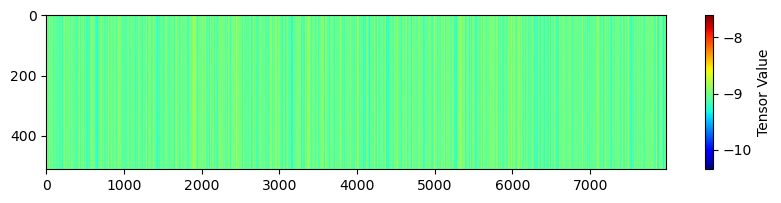

Model: "encoder_decoder_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_stack_6 (EncoderSta  multiple                 3163648   
 ck)                                                             
                                                                 
 decoder_stack_6 (DecoderSta  multiple                 4220416   
 ck)                                                             
                                                                 
 positional_embedding_12 (Po  multiple                 4086272   
 sitionalEmbedding)                                              
                                                                 
 positional_embedding_13 (Po  multiple                 4086272   
 sitionalEmbedding)                                              
                                                                 
 generator_6 (Generator)     multiple            

In [71]:
model = run_model(tokenizer, 
                  train_data, 
                  val_data, 
                  config)

# Inference

## WordComplete model

In [46]:
class WordComplete(tf.Module, ModuleVisualWrapper):
  def __init__(self, tokenizer, transformer, max_length=512, dtype=tf.Tensor, decode_result=True):
    super().__init__()
    ModuleVisualWrapper.__init__(self, vis_on_count=None)
    self.tokenizer = tokenizer
    self.transformer = transformer
    self.max_length = max_length
    self.dtype = dtype
    self.decode_result = decode_result

  def __call__(self, input, decode=True, encoding='utf-8'):
    
    # TODO: Bug with empty strings as input
    tensor_input = tf.convert_to_tensor(input)

    if len(tensor_input.shape) == 0:
      tensor_input = tensor_input[tf.newaxis]


    tokenized_input = self.tokenizer.tokenize(tensor_input, training=False).to_tensor()

    enc_input = tokenized_input
    context = self.transformer.encode(enc_input, None, training=False)

    end = enc_input[-1][-1]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)

    for i, value in enumerate(tokenized_input[0][:-1]):
      output_array = output_array.write(i, value)
    
    out_init_len = output_array.size()

    for i in tf.range(out_init_len, self.max_length):
      dec_input = output_array.concat()[tf.newaxis]

      decode = self.transformer.decode(context, None, dec_input, None, training=False)


      predictions = self.transformer.generator(decode, training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.


      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.

      output_array = output_array.write(i, predicted_id[0][0])

      if predicted_id == end:
        break

    output = output_array.concat()[tf.newaxis]

    # The output shape is `(1, tokens)`.
    text = self.tokenizer.detokenize(output)  # Shape: `()`.

    tokens = self.tokenizer.lookup(output)

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    # self.transformer([encoder_input, output[:,:-1]], training=False)
    # attention_weights = self.transformer.decoder.last_attn_scores

    if self.decode_result:
      text = text.numpy()[0].decode(encoding)

    ModuleVisualWrapper.reset_counter()

    

    return text, tokens # , attention_weights

## Infer text

In [47]:
inference_model = WordComplete(tokenizer, model, max_length=32)

string = "Where"

text, tokens = inference_model(string)

print(text)

This is the data from StoryTokenizer
[['[START]', 'where', '[END]']]
[START] where the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


In [ ]:
ModuleVisualWrapper.instances[0].counter